## This starts as an exploration for Titanic: Machine Learning from Disaster
## Multiple algorithms will be explored to get myself familiar with the common solutions

In [34]:
# Imports

# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn import metrics

from sklearn import preprocessing



In [2]:
# get titanic & test csv files as a DataFrame
titanic_df = pd.read_csv("train.csv")

# preview the data
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### step 1: clean the data 

In [4]:
titanic_df.info()
print("----------------------------")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------


## Step 2: visualize and clean data

#### Pclass

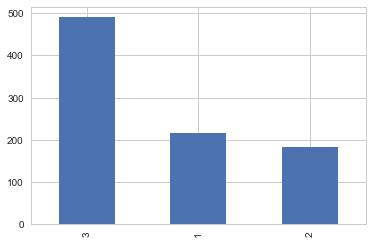

In [5]:
### check Pclass first
fig, ax = plt.subplots()
titanic_df['Pclass'].value_counts().plot(ax=ax, kind='bar')

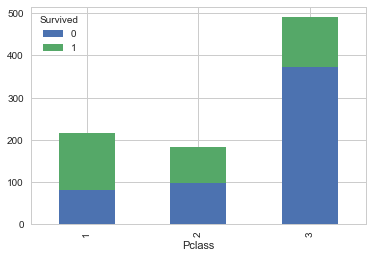

In [6]:
titanic_df_pclass = titanic_df.groupby(['Pclass', 'Survived'])['Survived'].count().unstack(level=-1)
titanic_df_pclass.plot(kind='bar', stacked=True)

In [7]:
titanic_df.groupby('Pclass')['Survived'].value_counts(normalize=True).xs(1,level='Survived')

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

#### sex

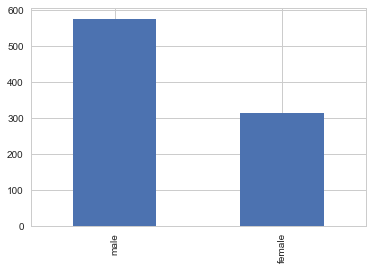

In [8]:
## sex
fig, ax = plt.subplots()
titanic_df['Sex'].value_counts().plot(ax=ax, kind='bar')

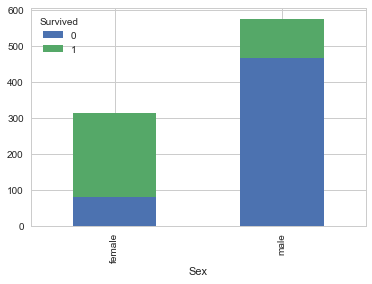

In [9]:
titanic_df_sex = titanic_df.groupby(['Sex', 'Survived'])['Survived'].count().unstack(level=-1)
titanic_df_sex.plot(kind='bar', stacked=True)

In [10]:
## replace sex with indicator
titanic_df.groupby('Sex')['Survived'].value_counts(normalize=True).xs(1,level='Survived')

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

In [11]:
## replace sex with indicator for model building
# titanic_df['Sex'] = titanic_df['Sex'].map({'female': 1, 'male': 0})

#### age

In [48]:
## test how to interpolate age parameter
## this methodology can be improved significantly after understanding other factors

age_avg  = titanic_df['Age'].mean()
age_std = titanic_df['Age'].std()
age_null_count = titanic_df['Age'].isnull().count()

age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
titanic_df['Age'][np.isnan(titanic_df['Age'])] = age_null_random_list
titanic_df['Age'] = titanic_df['Age'].astype(int)

/Users/tomzzh/Documents/After-Cornell/kaggle/titanic/env/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [79]:
titanic_df['age_categories'].isnull().sum()

0

In [77]:
## age
## it is interesting to check how other people are interpreting this variable
## group age together into bins to see the distribution
## reference: https://chrisalbon.com/python/pandas_binning_data.html
bins = [float("-inf"), 10, 35, 60, float("inf")]
group_names = ['child', 'youth', 'adult', 'old']
titanic_df['age_categories'] = pd.cut(titanic_df['Age'], bins, labels=group_names)

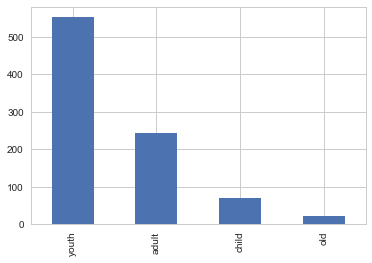

In [78]:
fig, ax = plt.subplots()
titanic_df['age_categories'].value_counts().plot(ax=ax, kind='bar')

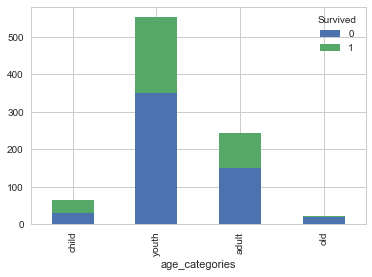

In [51]:
titanic_df_age_category = titanic_df.groupby(['age_categories', 'Survived'])['Survived'].count().unstack(level=-1)
titanic_df_age_category.plot(kind='bar', stacked=True)

In [52]:
titanic_df.groupby('age_categories')['Survived'].value_counts(normalize=True).xs(1,level='Survived')

age_categories
child    0.515625
youth    0.368897
adult    0.381148
old      0.217391
Name: Survived, dtype: float64

#### Embark

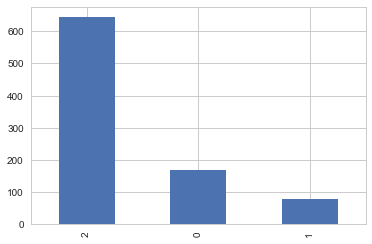

In [53]:
## Embarked
## try to find whether embarkation affects the probability
fig, ax = plt.subplots()
titanic_df['Embarked'].value_counts().plot(ax=ax, kind='bar')

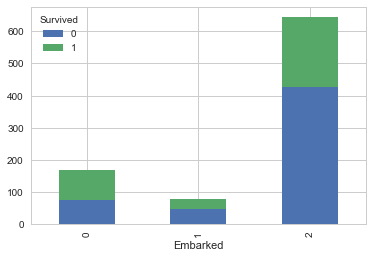

In [54]:
titanic_df_embark = titanic_df.groupby(['Embarked', 'Survived'])['Survived'].count().unstack(level=-1)
titanic_df_embark.plot(kind='bar', stacked=True)

In [55]:
## replace string with the right proxy
# titanic_df['Embarked'] = titanic_df['Embarked'].map({'C': 0, 'Q': 1, 'S':2})

In [56]:
## fill NA with right number
titanic_df['Embarked']=titanic_df['Embarked'].fillna('C')

In [57]:
titanic_df.groupby('Embarked')['Survived'].value_counts(normalize=True).xs(1,level='Survived')

Embarked
0    0.558824
1    0.389610
2    0.336957
Name: Survived, dtype: float64

#### some feature engineering

#### convert variable sibsp and parch to family size

In [58]:
#### family size 
titanic_df['family_size'] = titanic_df['SibSp'] + titanic_df['Parch'] + 1
titanic_df.groupby('family_size')['Survived'].value_counts(normalize=True).xs(1,level='Survived')

family_size
1    0.303538
2    0.552795
3    0.578431
4    0.724138
5    0.200000
6    0.136364
7    0.333333
Name: Survived, dtype: float64

In [59]:
## check whether single really matters in terms of family size
def family_resize(x):
    return 0 if x is 1 else 1
titanic_df['family_size_refined'] = titanic_df['family_size'].apply(lambda x:family_resize(x))

In [60]:
titanic_df.groupby('family_size_refined')['Survived'].value_counts(normalize=True).xs(1,level='Survived')

family_size_refined
0    0.303538
1    0.505650
Name: Survived, dtype: float64

#### convert fare to average fare based on family size

In [61]:
#### check whether average fare is a better indicator than fare
titanic_df['avg_fare'] = titanic_df['Fare']/titanic_df['family_size']

In [62]:
print(titanic_df[['avg_fare']].describe())

         avg_fare
count  891.000000
mean    19.916375
std     35.841257
min      0.000000
25%      7.250000
50%      8.300000
75%     23.666667
max    512.329200


In [63]:
### this is a test
bins = [-1, 7.25, 8.3, 23.7, float("inf")]
group_names = ['cheap', 'lower-level', 'mid-level', 'expensive']
titanic_df['fare_categories'] = pd.cut(titanic_df['avg_fare'], bins, labels=group_names)

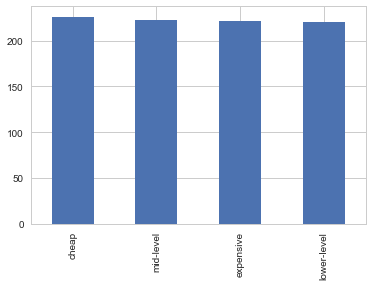

In [64]:
fig, ax = plt.subplots()
titanic_df['fare_categories'].value_counts().plot(ax=ax, kind='bar')

In [30]:
titanic_df.groupby('fare_categories')['Survived'].value_counts(normalize=True).xs(1,level='Survived')

fare_categories
cheap          0.265487
lower-level    0.254545
mid-level      0.408072
expensive      0.608108
Name: Survived, dtype: float64

### clean test data

In [80]:
### read test data separately to avoid pollution
test_df = pd.read_csv("test.csv")

In [81]:
age_avg  = test_df['Age'].mean()
age_std = test_df['Age'].std()
age_null_count = test_df['Age'].isnull().count()

age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
test_df['Age'][np.isnan(test_df['Age'])] = age_null_random_list
test_df['Age'] = test_df['Age'].astype(int)

/Users/tomzzh/Documents/After-Cornell/kaggle/titanic/env/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [82]:
# test_df['Sex'] = test_df['Sex'].map({'female': 1, 'male': 0})
# test_df['Embarked'] = test_df['Embarked'].map({'C': 0, 'Q': 1, 'S':2})
bins = [float("-inf"), 10, 35, 60, float("inf")]
group_names = ['child', 'youth', 'adult', 'old']
test_df['age_categories'] = pd.cut(test_df['Age'], bins, labels=group_names)

In [84]:
test_df['family_size'] = test_df['SibSp'] + test_df['Parch'] + 1
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].median())
test_df['avg_fare'] = test_df['Fare']/test_df['family_size']
bins = [-1, 7.25, 8.3, 23.7, float("inf")]
group_names = ['cheap', 'lower-level', 'mid-level', 'expensive']
test_df['fare_categories'] = pd.cut(test_df['avg_fare'], bins, labels=group_names)

## Step 3: encoding

In [87]:
def encode_features(df_train, df_test):
    features = ['Pclass','family_size','Sex','age_categories','Embarked','fare_categories']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test
    
data_train, data_test = encode_features(titanic_df, test_df)
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_categories,family_size,family_size_refined,avg_fare,fare_categories
0,1,0,2,"Braund, Mr. Owen Harris",1,22,1,0,A/5 21171,7.2500,NaN,2,3,1,1,3.62500,0
1,2,1,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38,1,0,PC 17599,71.2833,C85,0,0,1,1,35.64165,1
2,3,1,2,"Heikkinen, Miss. Laina",0,26,0,0,STON/O2. 3101282,7.9250,NaN,2,3,0,0,7.92500,2
3,4,1,0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35,1,0,113803,53.1000,C123,2,3,1,1,26.55000,1
4,5,0,2,"Allen, Mr. William Henry",1,35,0,0,373450,8.0500,NaN,2,3,0,0,8.05000,2


## Step 4: model building and selection

#### try to build a simple model before diving into deep

In [88]:
titanic_df_feature = titanic_df[['Survived','Pclass','family_size','age_categories','Sex','Embarked','fare_categories']]
test_df_feature = test_df[['Pclass','family_size','PassengerId','age_categories','Sex','Embarked','fare_categories']]

In [89]:
titanic_df_feature.head(5)

,Survived,Pclass,family_size,age_categories,Sex,Embarked,fare_categories
0,0,2,1,3,1,2,0
1,1,0,1,0,0,0,1
2,1,2,0,3,0,2,2
3,1,0,1,3,0,2,1
4,0,2,0,3,1,2,2


#### cross validation

In [90]:
X = titanic_df_feature.values
y = titanic_df_feature['Survived'].values
 #drop survived  column
X


array([[0, 2, 1, ..., 1, 2, 0],
       [1, 0, 1, ..., 0, 0, 1],
       [1, 2, 0, ..., 0, 2, 2],
       ..., 
       [0, 2, 3, ..., 0, 2, 0],
       [1, 0, 0, ..., 1, 0, 1],
       [0, 2, 0, ..., 1, 1, 2]])

In [91]:
X = np.delete(X,0,axis=1) 
X

array([[2, 1, 3, 1, 2, 0],
       [0, 1, 0, 0, 0, 1],
       [2, 0, 3, 0, 2, 2],
       ..., 
       [2, 3, 3, 0, 2, 0],
       [0, 0, 3, 1, 0, 1],
       [2, 0, 3, 1, 1, 2]])

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)
model_cross_validation = LogisticRegression()
model_cross_validation.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [93]:
predicted = model_cross_validation.predict(X_test)

In [94]:
print metrics.accuracy_score(y_test, predicted)

0.820895522388


In [95]:
print metrics.confusion_matrix(y_test, predicted)
print metrics.classification_report(y_test, predicted)

[[153  21]
 [ 27  67]]
             precision    recall  f1-score   support

          0       0.85      0.88      0.86       174
          1       0.76      0.71      0.74        94

avg / total       0.82      0.82      0.82       268



#### Now let's try 10-fold cross-validation, to see if the accuracy holds up more rigorously.

In [96]:
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print scores
print scores.mean()

[ 0.77777778  0.8         0.78651685  0.83146067  0.78651685  0.7752809
  0.80898876  0.78651685  0.83146067  0.79545455]
0.797997389627


the model below does not have a cross validaiton

In [97]:
X_train = titanic_df_feature.drop("Survived",axis=1)
Y_train = titanic_df_feature["Survived"]
X_test  = test_df_feature.drop("PassengerId",axis=1).copy()

In [98]:
# Logistic Regression

# should have created training and testing data to see the real difference

logreg = LogisticRegression()

logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

logreg.score(X_train, Y_train)

0.80920314253647585

In [99]:
logreg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [100]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('titanic.csv', index=False)